# intro tests

This notebook has a number of expamples to get familiar with bfd and des images.

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing
from functools import partial
import meds
import psfex
import bfd
import os
import galsim
import ngmix.gmix as gmix
from bfd import momentcalc as mc
from bfd.momenttable import TemplateTable, TargetTable
import astropy.io.fits as fits
import copy
from scipy.interpolate import CloughTocher2DInterpolator
from astropy import version 
import pyfits as pf
import ngmix
import frogress
import copy
from astropy import units as uu
from astropy.coordinates import SkyCoord
from bfd import momentcalc as mc
import sxdes
import pickle


def render_gal(gal_pars,psf_pars,wcs,shape, g1 = None, g2 = None,return_PSF=False,nbrxyref=None):
    
    try:
        if psf_pars['turb']:
            psf_gmix = ngmix.GMixModel(pars=psf_pars['pars'], model="turb")
    except:
        psf_gmix=gmix.GMix(pars=psf_pars)
        
    det=np.abs(wcs.getdet()) 
    
    jac=ngmix.jacobian.Jacobian(row=wcs.xy0[1],
                      col=wcs.xy0[0],
                      dudrow=wcs.jac[0,1],
                      dudcol=wcs.jac[0,0],
                      dvdrow=wcs.jac[1,1],
                      dvdcol=wcs.jac[1,0])

    if len(gal_pars) == 60:
        g_ =  copy.deepcopy(gal_pars)
        gmix_sky = ngmix.GMix(pars=g_.reshape(60))
 

    else:
        gmix_sky = gmix.GMixModel(gal_pars, model='bdf')

    if (g1  != None) and (g2  != None):
        gmix_sky = gmix_sky.get_sheared(g1,g2)
    gmix_image = gmix_sky.convolve(psf_gmix)
    
    try:
        im_psf = psf_gmix.make_image((shape,shape), jacobian=jac)#,fast_exp=True)    
        if nbrxyref!= None:
            v, u = jac(nbrxyref[1],nbrxyref[0])
       
            gmix_image.set_cen(v, u)
        
        image = gmix_image.make_image((shape,shape), jacobian=jac)#, fast_exp=True)
        
        
        #print ('succ')
    except:
        #print ('fail')
        if return_PSF:
            return None,None,jac
        else:
            
            return None,jac

    if return_PSF:
         return image,im_psf,jac
    else:
            
        return image,jac
    

def _add_T_and_scale(obj_data, scale):
    add_dt = [('T', 'f4')]
    objs = eu.numpy_util.add_fields(obj_data, add_dt)
    objs['flux'] *= scale**2
    min_sigma = scale
    min_T = 2*min_sigma**2
    T = 2*objs['hlr']**2
    T = T.clip(min=min_T)
    objs['T'] = T
    return objs


# Load DES Y6 Wide field images

We load from the data the world coordinate system (wcs), which tells use how to map pixel coordinates (x,y) to real image coordinates (u,v). In practice, this is obtained by specifying the Jacobian of the coordinate transformation (it's a 2x2 matrix). For DES, a good approximation is: 

duv_dxy = np.array([[0.263, 0.],[0., 0.263]])

which tells us that the pixel scale is ~0.263 arcseconds.

We also load from 
                                        

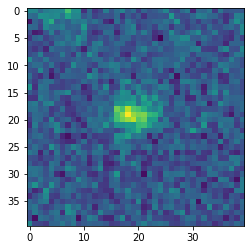

In [3]:
# load 1 image from 1 tile in the i-band.
import glob
file = '/global/cscratch1/sd/mgatti/BFD/data/r/DES0158-3206_r5219p01_r_meds-Y6A2_MEDS.fits.fz'

path = '/global/cscratch1/sd/mgatti/BFD/data/r/' 
files = glob.glob(path+'*')
file = files[0]

# DES imagescome in the form of mulit-epoch data structure files (MEDS).
m = meds.MEDS(file)


# let's select the image number 500.
index = 500
# list of the actually images
imlist =   np.array(m.get_cutout_list(index))[0,:,:]
# weitgh map (tells us the noise)
wtlist =   np.array(m.get_cutout_list(index, type='weight'))[0,:,:]
# masked pixels
masklist = np.array(m.get_cutout_list(index, type='bmask') )[0,:,:]
# list of wcs
jaclist =  np.array(m.get_jacobian_list(index) )[0]



ra = m['ra'][index] 
dec = m['dec'][index] 

plt.imshow(imlist) 
plt.show() 

# make wcs for BFD
cent=(jaclist['col0'],jaclist['row0'])
origin = (0.,0.)
duv_dxy = np.array( [ [jaclist['dudcol'], jaclist['dudrow']],
                      [jaclist['dvdcol'], jaclist['dvdrow']] ])
wcs = bfd.WCS(duv_dxy,xyref=cent,uvref=origin)

# converting it into ngmix format:
jac=ngmix.jacobian.Jacobian(row=wcs.xy0[1],
                      col=wcs.xy0[0],
                      dudrow=wcs.jac[0,1],
                      dudcol=wcs.jac[0,0],
                      dvdrow=wcs.jac[1,1],
                      dvdcol=wcs.jac[1,0])

# simulate a galaxy image

In [4]:
# let's load a galaxy parametetric model. in this model (called BDF...not to confuse with BFD!), you need 7 parameters to describe a galaxy.
# you also have psf model...that requires 30 parameters.
p = './data/all_100k_10k_size.npy'
MOF_best_fits = np.load(p,allow_pickle=True).item()
gal_index = 1325

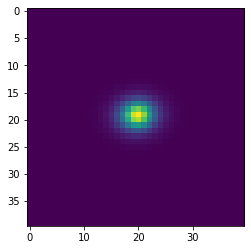

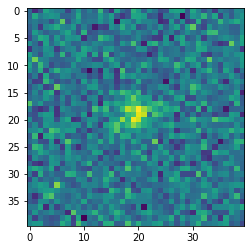

In [5]:
# this is inducing a shear in the target galaxy:
g1=0.02
g2=0.0

# shape of the image (40x40)
shape = 40
# let's use the noise from the des y6 stamp.
noise_rms = 1./np.sqrt(np.median(wtlist))


# get determinant of wcs
det=np.abs(wcs.getdet()) 

# render psf. Two options here: either use the psf from the model we just loaded; 
#psf_gmix=gmix.GMix(pars=MOF_best_fits[gal_index]['r']['pfs_params'])

# or generate a simple gaussian psf:
psf_fwhm = 1.
Tpsf = ngmix.moments.fwhm_to_T(psf_fwhm)
psf_pars = [0.0, 0.0, 0.0, -0.00, Tpsf, 1.0]

# this renders the psf!
psf_gmix = ngmix.GMixModel(pars=psf_pars, model="turb")



# galaxy parameters ************************

gpars = MOF_best_fits[gal_index]['r']['gal_pars']

# randomly rotate the galaxy
gp = copy.deepcopy(gpars)
twotheta = 2.0 * np.radians(np.random.randint(0,36000)*1./100.)
cos2angle = np.cos(twotheta)
sin2angle = np.sin(twotheta)


mm1= gp[2] * cos2angle +  gp[3] * sin2angle
mm2= -gp[2] * sin2angle + gp[3] * cos2angle
gp[2] = copy.copy(mm1)
gp[3] = copy.copy(mm2)
            
        
        
gp = copy.deepcopy(gpars)


# first get the unsheared image *************

gmix_sky = gmix.GMixModel(gp, model='bdf')
gmix_sky = gmix_sky.get_sheared(g1,g2)
gmix_image = gmix_sky.convolve(psf_gmix)

# render full image *******
image = gmix_image.make_image((shape,shape), jacobian=jac, fast_exp=True)
im_psf =  psf_gmix.make_image((shape,shape), jacobian=jac,fast_exp=True)
plt.imshow(image)
plt.show()

# add noise
noise = np.random.normal(size = (shape,shape))*noise_rms
image += noise

plt.imshow(image)
plt.show()





# compute bfd moments

Moments:  [ 3385.31450235 12448.7469583  -1523.8605048   -840.56212356
 79406.94699308]
S/N: 12.90


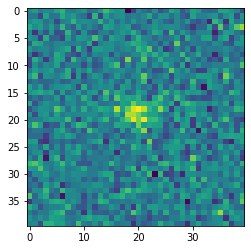

In [6]:
# let's measure moments ******
n = 4.
sigma = 0.55
pad_factor = 3.
band_dict = dict()
band_dict['bands'] = ['r']
band_dict['weights'] = [1]
band_dict['index'] = [0]

# *************************

psf_fwhm = 1
Tpsf = ngmix.moments.fwhm_to_T(psf_fwhm)
psf_pars = [0.0, 0.0, 0., -0.00, Tpsf, 1.0]
psf_gmix = ngmix.GMixModel(pars=psf_pars, model="turb")
gpars = MOF_best_fits[gal_index]['r']['gal_pars']

gp = copy.deepcopy(gpars)
twotheta = 2.0 * np.radians(np.random.randint(0,36000)*1./100.)
cos2angle = np.cos(twotheta)
sin2angle = np.sin(twotheta)


mm1= gp[2] * cos2angle +  gp[3] * sin2angle
mm2= -gp[2] * sin2angle + gp[3] * cos2angle
gp[2] = copy.copy(mm1)
gp[3] = copy.copy(mm2)
            

gp = copy.deepcopy(gpars)
gmix_sky = gmix.GMixModel(gp, model='bdf')
gmix_sky = gmix_sky.get_sheared(g1*0.,g2*0.)
gmix_image = gmix_sky.convolve(psf_gmix)

image_sheared = gmix_image.make_image((shape,shape), jacobian=jac, fast_exp=True)
im_psf =  psf_gmix.make_image((shape,shape), jacobian=jac,fast_exp=True)



noise_rms = 1./np.sqrt(np.median(wtlist))
noise = np.random.normal(size = (shape,shape))*noise_rms
image_sheared += noise

    
    
kds = bfd.multiImage([image_sheared], (0,0), [im_psf], [wcs], pixel_noiselist = [noise_rms], bandlist = ['r'],pad_factor=pad_factor)
wt = mc.KSigmaWeight(sigma = sigma) 
mul = bfd.MultiMomentCalculator(kds, wt, bandinfo = band_dict)
xyshift, error,msg = mul.recenter()
moments = mul

mom = moments.get_moment(0,0)
print ('Moments: ',mom.even)
print ('S/N: {0:2.2f}'.format(mom.even[mom.M0]/np.sqrt(moments.get_covariance()[0][mom.M0,mom.M0])))

plt.imshow(image_sheared)

# Generate a tile and detect galaxies

In DES, we use sExtractor to detect images.  let's create a large stamp with a few galaxies in it. 

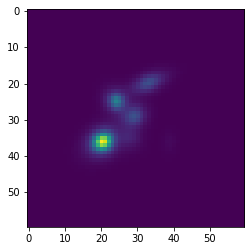

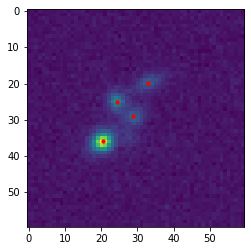

In [7]:
size_tile = 60
n_sources = 7
g1 = 0.02
g2 = 0.
band = 'r'
# *****
tile = dict()
tile['image'] = np.zeros((size_tile,size_tile))

x_ = np.random.randint(20,size_tile-20,n_sources)
y_ = np.random.randint(20,size_tile-20,n_sources)        

 
# shear positions. ************************************************************
x_a = []
y_a = []
shear = galsim.Shear(g1=g1, g2=g2)


a = shear.getMatrix()
for i in range(len(x_)):
    # we need the canonical image center in (u, v) for undoing the
    # shearing

    row_cen = x_[i]
    col_cen = y_[i]


    jac = ngmix.jacobian.Jacobian(row=  size_tile/2.,
          col =  size_tile/2.,
          dudrow=0.,
          dudcol=0.263,
          dvdrow=0.263,
          dvdcol=0.)

    v_cen, u_cen = jac.get_vu(row=size_tile/2., col=size_tile/2.)

    # apply WCS to get to world coords
    v, u = jac.get_vu(row=row_cen, col=col_cen)

    # unshear (subtract and then add the canonical center in u, v)
    u = np.atleast_1d(u) - u_cen
    v = np.atleast_1d(v) - v_cen

    #print (u,v)

    pos = np.vstack((u, v))

    out = np.dot(a, pos)
    assert out.shape[1] == u.shape[0]
    u_sheared = out[0, :] + u_cen
    v_sheared = out[1, :] + v_cen

    rows_sheared, cols_sheared = jac.get_rowcol(v=v_sheared, u=u_sheared)

    x_a.append(rows_sheared[0])
    y_a.append(cols_sheared[0])
                        
# random psf for the tile *****************************************************************
psf_fwhm = 0.9+(np.random.random(1)*0.3)[0] #fwhm...des has around ~1.
Tpsf = ngmix.moments.fwhm_to_T(psf_fwhm)
psf_pars_ = {'pars':[.0, 0., 0., 0., Tpsf, 1.0],'turb':True}
            
pp = list(MOF_best_fits.keys())

for real in range(n_sources):
    # make WCS for the object 
    cent=(x_a[real],y_a[real])
    origin = (0.,0.)
    duv_dxy = np.array([[0.263, 0.],
                        [0., 0.263]])
    wcs_ = bfd.WCS(duv_dxy,xyref=cent,uvref=origin)
    p0 = pp[np.random.randint(0,len(pp),1)[0]] 
    gp = MOF_best_fits[p0][band]['gal_pars']
    # (gp[4] is the size of the object. you might want to ignore objects with size larger than 2).
    
    twotheta = 2.0 * np.radians(np.random.randint(0,36000)*1./100.)
    cos2angle = np.cos(twotheta)
    sin2angle = np.sin(twotheta)
    
    mm1= gp[2] * cos2angle +  gp[3] * sin2angle
    mm2= -gp[2] * sin2angle + gp[3] * cos2angle
    gp[2] = copy.copy(mm1)
    gp[3] = copy.copy(mm2)
    
    
    
    
    mute_p,_,jac = render_gal(gp,psf_pars_,wcs_,size_tile, g1 = g1, g2 = g2,return_PSF=True)
    tile['image'] += mute_p
    

plt.imshow(tile['image'])  
plt.show()


# add noise
noise = np.random.normal(size = (size_tile,size_tile))*noise_rms
tile['image'] +=  noise                    
plt.imshow(tile['image'])  
    
    
    
# detect galaxies :  
cat, seg = sxdes.run_sep(tile['image'], noise_rms)
plt.scatter(cat['x'],cat['y'],color='red',s=10)       

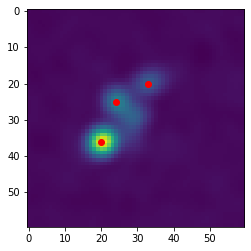

In [8]:
# bfd moments Mf detection
sigma = 0.55

#render the psf. needs to be at the center of the stamp!
cent=(size_tile/2.,size_tile/2.)
origin = (0.,0.)
duv_dxy = np.array([[0.263, 0.],
                    [0., 0.263]])
wcs_ = bfd.WCS(duv_dxy,xyref=cent,uvref=origin)
_,psf_,_ = render_gal(gp,psf_pars_,wcs_,size_tile, g1 = 0., g2 = 0.,return_PSF=True)
    
    
    
# now, let's construct an effective 'flux moment' map by computing Mf for every pixel of the tile.

# start from one corner.
cent=(0,0)
origin = (0.,0.)
duv_dxy = np.array([[0.263, 0.],
                    [0., 0.263]])
wcs = bfd.WCS(duv_dxy,xyref=cent,uvref=origin)




kds = bfd.multiImage([tile['image']], (0,0), [psf_], [wcs], pixel_noiselist = [noise_rms], bandlist = ['r'],pad_factor=pad_factor)
wt = mc.KSigmaWeight(sigma = sigma) 
mul = bfd.MultiMomentCalculator(kds, wt, bandinfo = band_dict)
#xyshift, error,msg = mul.recenter()
moments = mul
cov,_ = moments.get_covariance()
sigma_mf = np.sqrt(cov[0,0])

mf_map = np.zeros(tile['image'].shape)
for i in range(tile['image'].shape[0]):
    for j in range(tile['image'].shape[0]):
        dx1,dy1 = wcs.getuv( np.array([i,j],dtype=float))
        mom = moments.get_moment(dy1,dx1)
        mf_map[i,j] = mom.even[0]/sigma_mf
        
        

# plot Mf flux map and maxima
def find_maxima(image1):
    # SN> 5 & larger than the 8 adjacent pixels.
    map_maxima = copy.deepcopy(image1)[1:-1,1:-1]
    max_map = np.zeros(image1.shape)
    max_map[1:-1,1:-1] = (map_maxima-image1[:-2,1:-1]>0.) & \
    (map_maxima-image1[1:-1,:-2]>0.) & \
    (map_maxima-image1[2:,1:-1]>0.) & \
    (map_maxima-image1[1:-1,2:]>0.) & \
    (map_maxima-image1[:-2,:-2]>0.) & \
    (map_maxima-image1[:-2,2:]>0.) & \
    (map_maxima-image1[2:,:-2]>0.) & \
    (map_maxima-image1[2:,2:]>0.) & (image1[1:-1,1:-1]>5.)
    
    return max_map
plt.imshow((mf_map))
plt.scatter(np.where(find_maxima(mf_map))[1],np.where(find_maxima(mf_map))[0],color='red')

# shredder

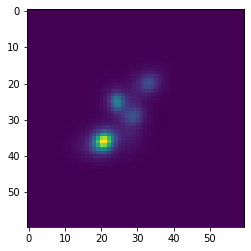

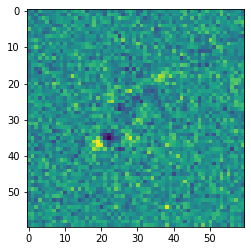

In [49]:
import shredder
import esutil as eu
seed = 113
rng = np.random.RandomState(seed)
guess_model = 'dev'
weight_map = np.ones_like(tile['image'])/noise_rms
jac_shredder = ngmix.jacobian.Jacobian(row= tile['image'].shape[0]/2.,
                                              col= tile['image'].shape[1]/2.,
                                              dudrow=wcs_.jac[0,1],
                                              dudcol=wcs_.jac[0,0],
                                              dvdrow=wcs_.jac[1,1],
                                              dvdcol=wcs_.jac[1,0])    

# neet do provide the psf to the shredder and recast it into a ngmix observation object
psf_o = ngmix.Observation(psf_,jacobian=jac_shredder)

# now we need to create a ngmix object for the tile
mbobs_ = ngmix.Observation(tile['image'],weight=weight_map,
                                    meta={"orig_row": (tile['image'].shape[0])/2., "orig_col": (tile['image'].shape[1])/2.},
                                    jacobian=jac_shredder,
                                    psf=psf_o)
mbobs_ = ngmix.observation.get_mb_obs(mbobs_)



dt = np.dtype([('shift', '<f4', (2,)),('flux', 'f4'), ('hlr', 'f4'),('col', 'f4'),('row', 'f4')])

       
# give guesses to shredder
m = []
for i in range(len(cat['flux'])):
    m.append(((0.,0.),cat['flux'][i],
            cat['flux_radius'][i],
            cat['x'][i],
            cat['y'][i]))
d_ = np.array([m],dtype=dt)
objs_ = _add_T_and_scale(d_[0],0.263)
gm_guess = shredder.get_guess(
    objs_,
    jacobian=mbobs_[0][0].jacobian,
    model=guess_model,
    rng=rng,
)

# run shredder
s = shredder.Shredder(obs=mbobs_, psf_ngauss=2, rng=rng)
s.shred(gm_guess)
res = s.get_result()
                            
# get models
models = s.get_model_images()

# render models ++++
plt.imshow(models[0])
plt.show()
# residuals
plt.imshow(tile['image']-models[0])

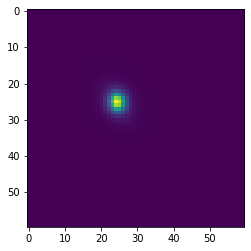

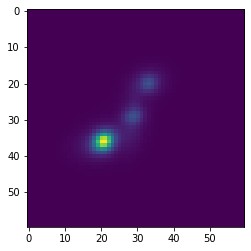

In [54]:
# now magine you want to render all the models exxcept one galaxy.


#coordinate target galaxy
x_ref = cat['x'][0]
y_ref = cat['y'][0]


# let's assume I want to render all the models outside a 0.5 arcsec radius of the target galaxy.
pa_= res['band_gmix_convolved'][0].get_data()
# centers of the models
x_ = pa_['col']/0.263+tile['image'].shape[0]/2.
y_ = pa_['row']/0.263+tile['image'].shape[1]/2.

catalog_input = SkyCoord(ra=x_*uu.arcsec*0.263, dec=y_*uu.arcsec*0.263)  
catalog_1 = SkyCoord(ra=[x_ref]*uu.arcsec*0.263, dec=[y_ref]*uu.arcsec*0.263)  
min_scale = 0.5        
idx_, Aidx, d2d, d3d = catalog_input.search_around_sky(catalog_1, min_scale*uu.arcsec)


pars = np.zeros(len(Aidx) * 6)
ref = 0
for i in range(len(Aidx)):
    pars[ref + 0] = pa_["p"][i]
    pars[ref + 1] = pa_["row"][i]
    pars[ref + 2] = pa_["col"][i]
    pars[ref + 3] = pa_["irr"][i]
    pars[ref + 4] = pa_["irc"][i]
    pars[ref + 5] = pa_["icc"][i]
    ref += 6
gm = ngmix.GMix(pars=pars)
im0 = gm.make_image((tile['image'].shape[0],tile['image'].shape[1]), jacobian=jac_shredder)
# model target galaxy
plt.imshow(im0)      
plt.show()
# all the other models
plt.imshow(models[0]-im0) 